In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
BES = pd.read_stata("../BES_analysis_data/BES2015_W8_v1.3.dta")

In [97]:
variable_categories = pd.read_csv("question_categories_correct.csv", encoding = "ISO-8859-1")
var_cat_dict = dict()
for typ in [1,2,3,4,5,6]:
    e = variable_categories[variable_categories.type==typ]["column_name"].values
    var_cat_dict[typ] = [item for sublist in [i.split("|") for i in e] for item in sublist]
    
var_type = pd.DataFrame(columns = ['type'] )
for col in BES.columns:
    dt= BES[col].dtype.name
    if ( col == "id" ):
        var_type.loc[col] = 7
        
    elif ( dt!='category' ) and ( dt!='float64' ):
        var_type.loc[col] = -1
    
    elif ( dt=='float64' ) and (col in ['personality_agreeableness', 'personality_conscientiousness','personality_extraversion', 'personality_neuroticism','personality_openness','mapNamesW3','riskScaleW8']):
        var_type.loc[col] = 0

    elif ( dt=='float64' ):
        var_type.loc[col] = -1

    elif ( dt=='category' ):
        var_type.loc[col] = 8 # Wave 9 stuff!
        for typ in [1,2,3,4,5,6]:
            if col in var_cat_dict[typ]:
                var_type.loc[col] = typ
            elif (col+"W8") in var_cat_dict[typ]:
                var_type.loc[(col)] = typ
#             elif col.endswith("W9") and col[:-2]+"W8" in var_cat_dict[typ]:
#                 var_type.loc[(col)] = typ
    else:
        print("what's up with this? " + col)
var_type["type"] = var_type["type"].astype("int8")
# var_type

In [27]:
var_type[var_type["type"]==3]

type
country                              3
generalElectionVote                  3
partyId                              3
partyIdSqueeze                       3
countryOfBirth                       3
bestOnMII                            3
localElectionVote                    3
welshElectionVoteConst               3
welshElectionVoteList                3
scotElectionVoteConst                3
scotElectionVoteList                 3
pccVote1                             3
pccVote2                             3
registered                           3
handed                               3
country_of_residence1                3
country_of_residence2                3
partyMemberPast                      3
partyMemberNow                       3
recallVote15                         3
EUMIICategory                        3
euMIISmall                           3
marital                              3
housing                              3
gor                                  3
education                            3
profile_ethnicity                    3
profile_lea                          3
profile_oslaua                       3
profile_newspaper_readership_201     3
profile_past_vote_2005               3
profile_past_vote_2010               3
profile_religion                     3
profile_religion_denom               3
ns_sec                               3
ns_sec_analytic                      3
workingStatus                        3
headHouseholdPast                    3
subjClass                            3
polKnowMiliband                      3
polKnowClegg                         3
polKnowOsborne                       3
polKnowMay                           3
polKnowBercow                        3
subjectHE                            3
subjectHECurrent                     3
profile_past_vote_2015               3

In [28]:
var_type[var_type["type"]==3].shape

(47, 1)

In [90]:
BES["countryOfBirth"].value_counts()

England                                 12718
Scotland                                 2643
Wales                                    1207
Other: Rest of world                      292
Other: European Union member country      262
Other: Commonwealth member country        249
Northern Ireland                           85
Prefer not to answer                       75
Republic of Ireland                        68
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001730C9E4630>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001730D337A20>]], dtype=object)

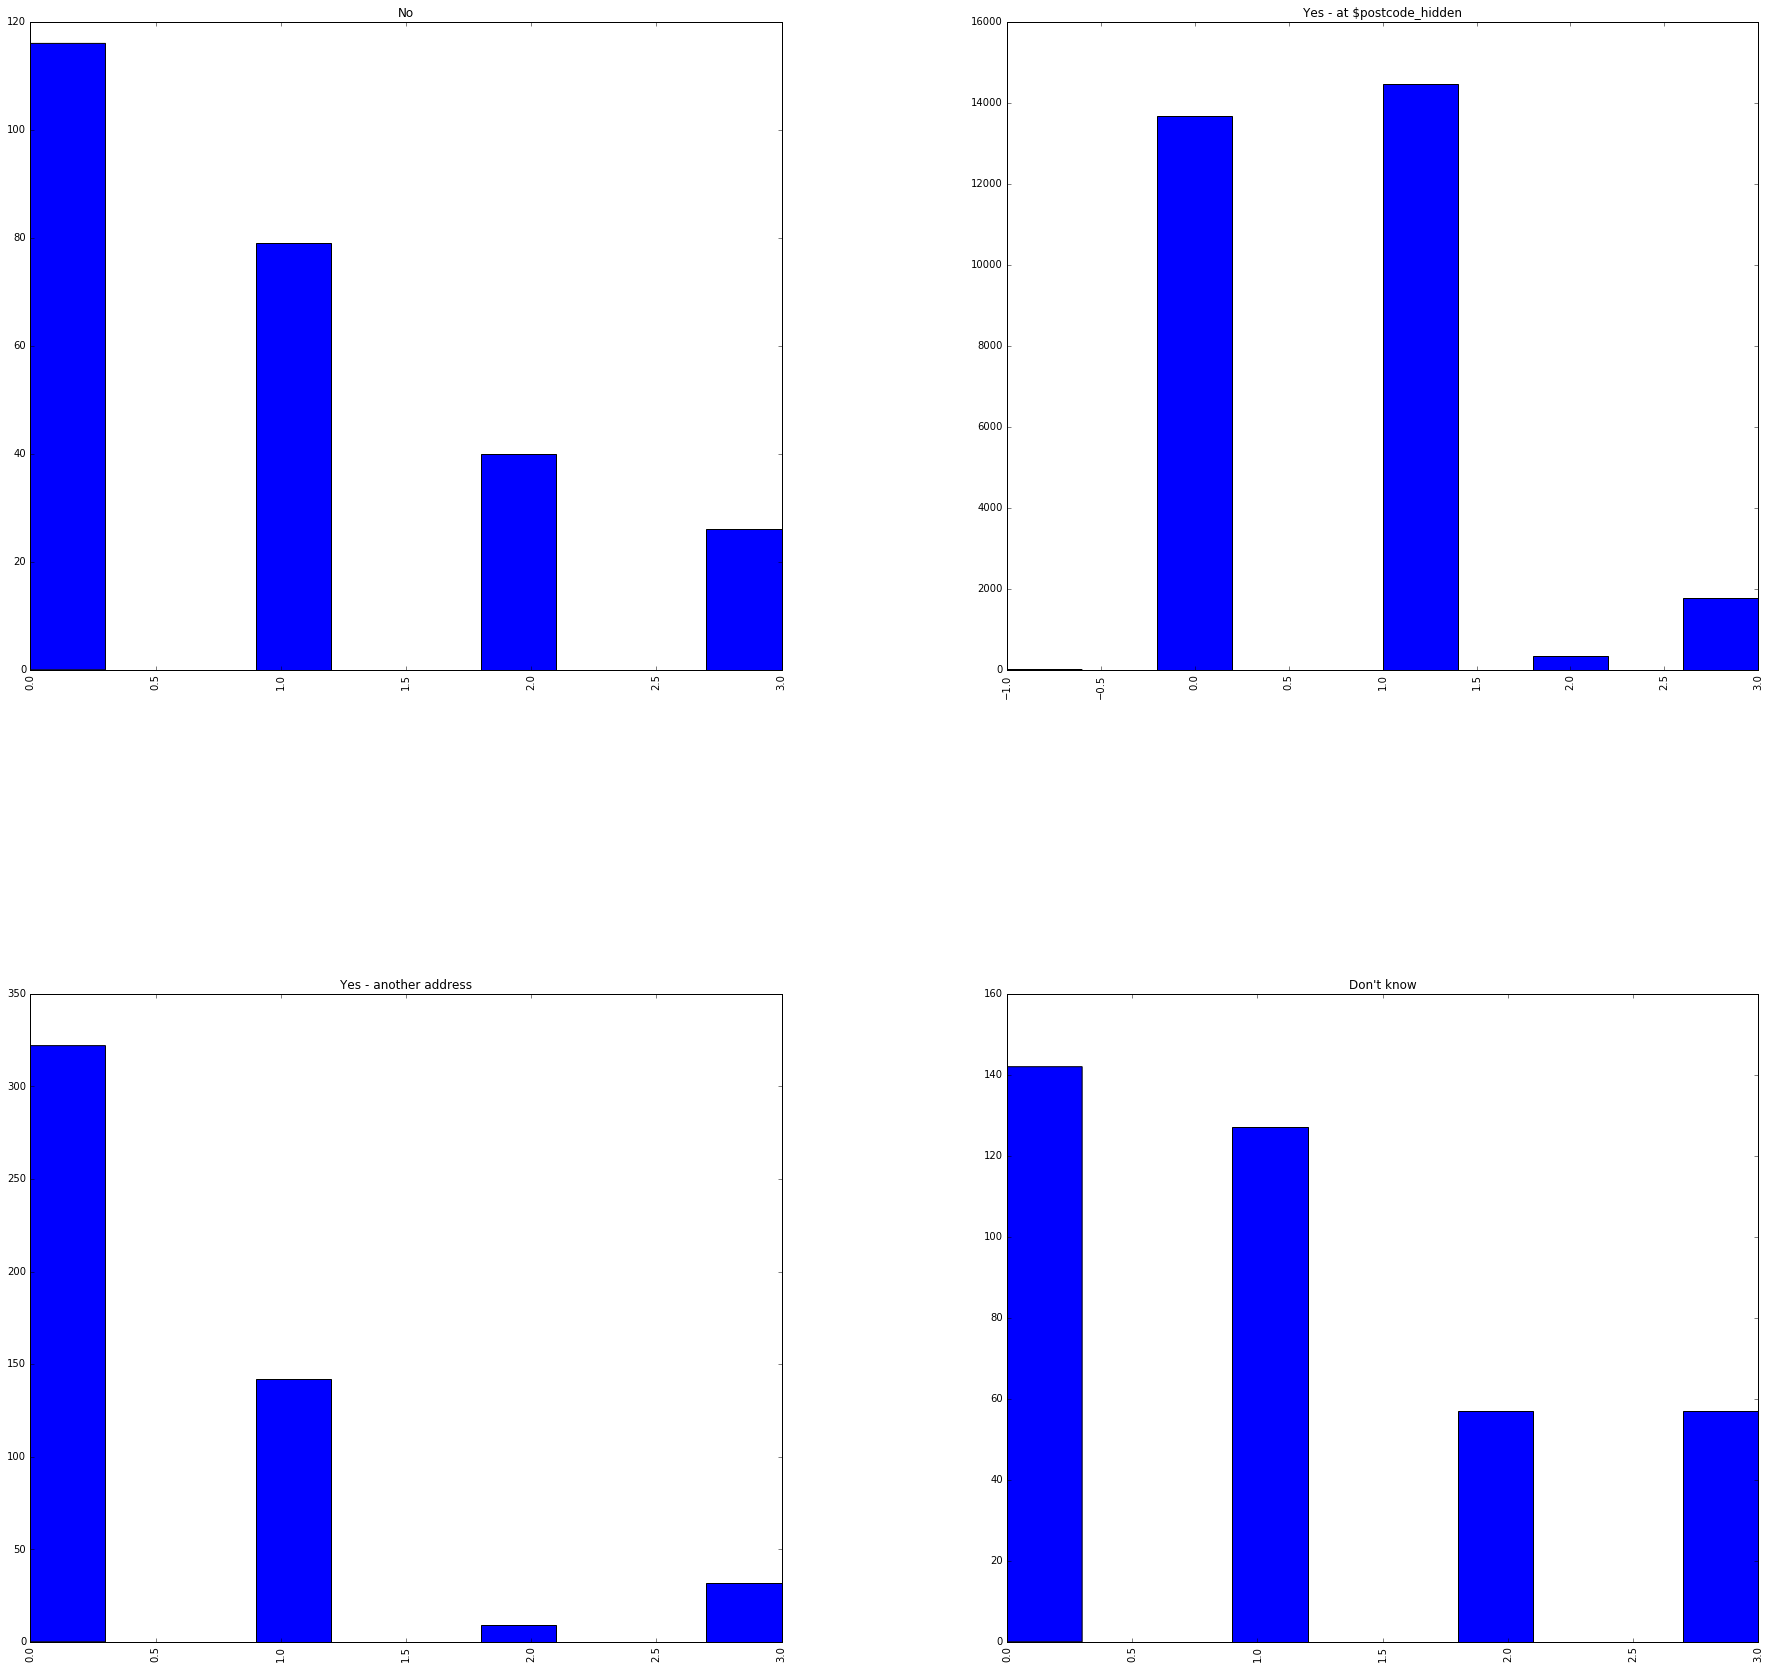

In [89]:
BES["euRefVote"].cat.codes.hist(by=BES["registered"],figsize=(30,30))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001730B69E780>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001730C005358>]], dtype=object)

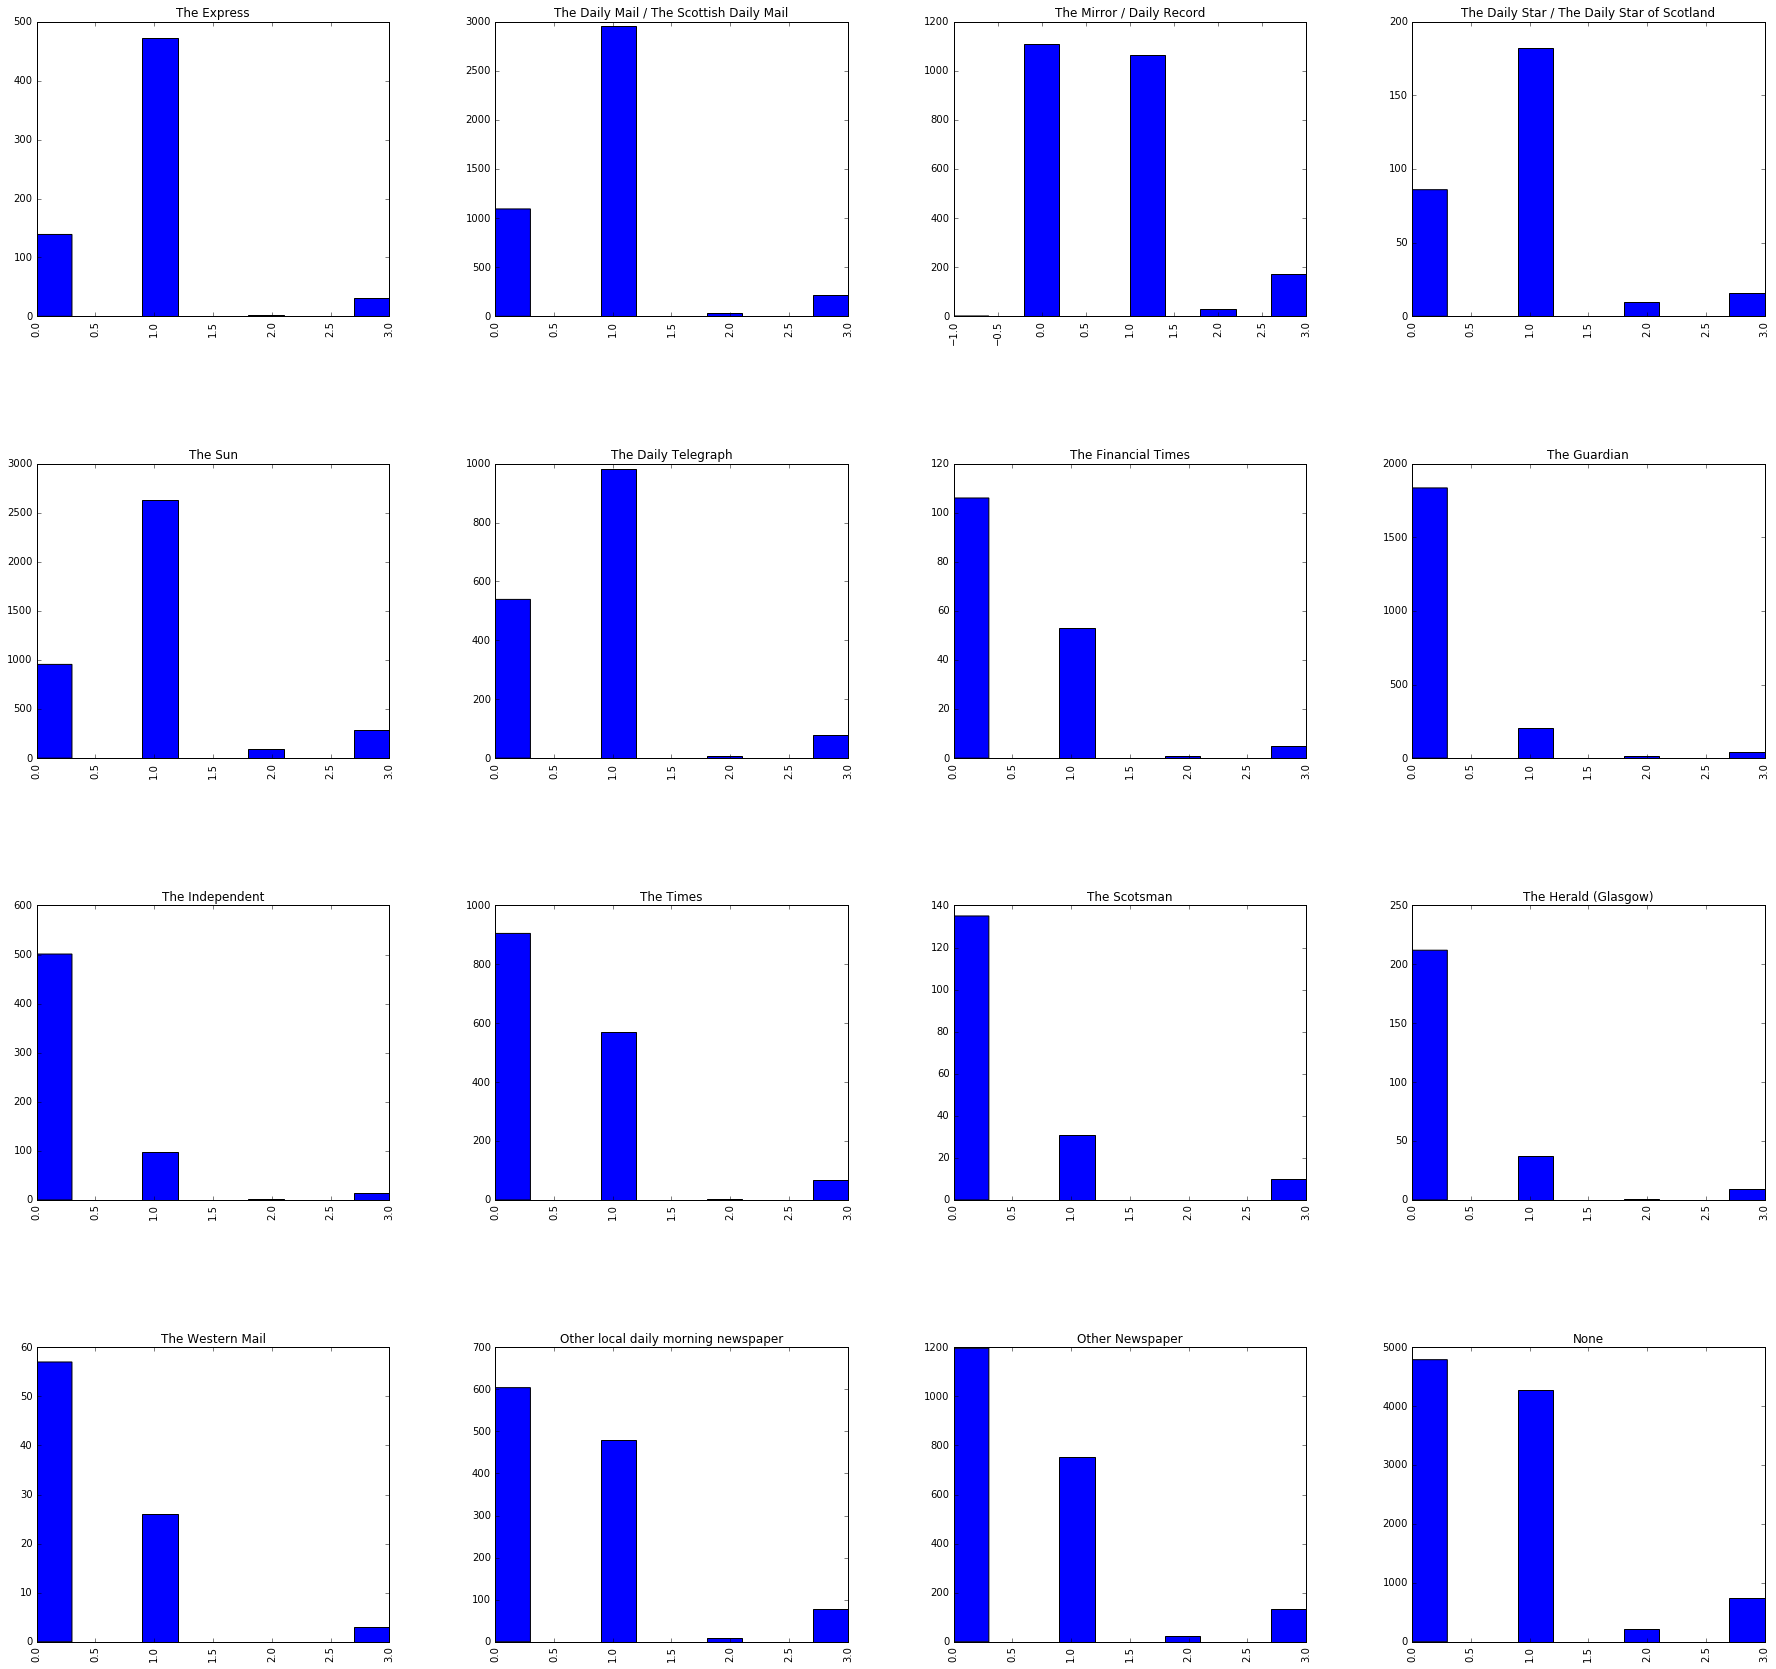

In [75]:
BES["euRefVote"].cat.codes.hist(by=BES["profile_newspaper_readership_201"],figsize=(30,30))

In [ ]:
########################### Categories (47)

# polKnow* (5):  -> 1/0 correct / not correct

#### party-variables (17)

# profile_past_vote_2015, profile_past_vote_2010, profile_past_vote_2005
# recallVote15
# pccVote1, pccVote2
# welshElectionVoteConst, welshElectionVoteList
# scotElectionVoteConst, scotElectionVoteList
# localElectionVote
# bestOnMII
# generalElectionVote
# partyId, partyIdSqueeze
# partyMemberPast, partyMemberNow

#### HE subjects (3)
# subjectHE, subjectHECurrent

# education <qualification type>

####  Misc (13)
# subjClass -> really just working class/middle class -> could make binary

# workingStatus  full time/part-time/small-part-time/retired/student ???
# headHouseholdPast  main wage earner in your house when 14

# ns_sec, ns_sec_analytics occupation category (big/small)

# profile_religion, profile_religion_denom

# profile_newspaper_readership_201 

# profile_ethnicity

# housing <how you pay for your accommodation>

# marital <marital status>

# handed (left handed, right handed, both, *don't know*)

# registered (are you registered here, somewhere else, not - almost everyone is!)

############## Reasons for voting (2)
# EUMIICategory, euMIISmall - why you voted to stay/leave (big list, small list)


############ Geography (6)
# profile_oslaua <local authority/constituency>
# profile_lea <local education authority>
# gor <region of the country>

# country_of_residence1, country_of_residence2 <full list of countries>
# countryOfBirth <smaller list with countries lumped together outside of England, Wales, Scotland

In [91]:
change_cat_dict = {"Bad time to buy|Good time to buy|Neither good nor bad time to buy|Don't know": ["Bad time to buy", "Neither good nor bad time to buy", "Good time to buy"],
                   "Larger|Smaller|About the same|Don't know": ["Larger", "About the same", "Smaller"],
                   "Mainly leave|Mainly remain|Fairly evenly split|Don't know": ["Mainly leave", "Fairly evenly split", "Mainly remain"],
                   'An individual share in a company|A portfolio of different company shares|The risk is the same|Don\x92t know|Prefer not to say': ['An individual share in a company', 'The risk is the same', 'A portfolio of different company shares'],
                   "No, I have never been a member|Yes, I am a member of a party|I am not a member now but I used to be|Don't know": ['No, I have never been a member', 'I am not a member now but I used to be', 'Yes, I am a member of a party'],
                   "Never or practically never|Less often than once a year|Less often but at least once a year|Less often but at least twice a year|Less often but at least once a month|Less often but at least once in two weeks|Once a week or more|Varies too much to say|I am not religious|Don't know": ['I am not religious', 'Never or practically never', 'Less often than once a year', 'Less often but at least once a year', 'Less often but at least twice a year', 'Less often but at least once a month', 'Less often but at least once in two weeks', 'Once a week or more']}
Weasel_answers = ["Don't know", 'Do\x92t know', 'Dont know', 'Donât know', "Prefer not to say", "Prefer not to answer", "Refused", "Unknown", "Neither", "Other", "I would/will not vote", "Will not vote", "I would not vote", "It depends", "Other", "Don’t follow politics on Facebook", "Don't follow politics on twitter", "9999.0", "997.0", "Yes, other", "Haven't thought about it", "There wasn't a local election in my area", "No, haven't received it", "I don't know what was negotiated", "I never received a response", "There are not local elections in my area", "Can't remember", "Varies too much to say" ]
Weasel_set = set(Weasel_answers)

In [92]:
BES_numeric = BES.copy()
pos = 0
for col in BES_numeric:
    print(100*pos/len(BES.columns))
    pos = pos + 1
    typ = var_type["type"][col]
    if (typ == -1) | (typ == 4):
        continue
        #BES_numeric.drop(col,axis=1,inplace=True)
        
    
    elif (typ == 2):
        new_cat_order = change_cat_dict["|".join(BES_numeric[col].cat.categories)]
        BES_numeric[col] = BES_numeric[col].cat.remove_categories( BES_numeric[col].cat.categories.intersection(Weasel_set) )
        BES_numeric[col] = BES_numeric[col].cat.reorder_categories( new_cat_order )

        BES_numeric[col] = BES_numeric[col].cat.codes
        BES_numeric.loc[ BES_numeric[col]==-1, col ] = np.nan  
        #BES_numeric[col][ BES_numeric[col]==-1 ] = np.nan  
        # .loc[row_index,col_indexer]

#         print( BES_numeric[col].cat.categories)
    
    elif (typ == 5) | (typ == 1): # (typ == 1) | 
        # remove weasel categories
#         continue

        BES_numeric[col] = BES_numeric[col].cat.remove_categories( BES_numeric[col].cat.categories.intersection(Weasel_set) )
        # change to numbers!
        BES_numeric[col] = BES_numeric[col].cat.codes
        BES_numeric.loc[ BES_numeric[col]==-1, col ] = np.nan
        #BES_numeric[col][ BES_numeric[col]==-1 ] = np.nan

    elif (typ == 6):

        BES_numeric[col] = BES_numeric[col].cat.remove_categories( BES_numeric[col].cat.categories.intersection(Weasel_set) )
        BES_numeric[col] = BES_numeric[col].astype('float64')


0.0
0.1364256480218281
0.2728512960436562
0.4092769440654843
0.5457025920873124
0.6821282401091405
0.8185538881309686
0.9549795361527967
1.0914051841746248
1.2278308321964528
1.364256480218281
1.500682128240109
1.6371077762619373
1.7735334242837653
1.9099590723055935
2.0463847203274215
2.1828103683492497
2.319236016371078
2.4556616643929057
2.592087312414734
2.728512960436562
2.8649386084583903
3.001364256480218
3.1377899045020463
3.2742155525238745
3.4106412005457027
3.5470668485675305
3.6834924965893587
3.819918144611187
3.956343792633015
4.092769440654843
4.229195088676671
4.365620736698499
4.502046384720328
4.638472032742156
4.774897680763984
4.911323328785811
5.04774897680764
5.184174624829468
5.320600272851296
5.457025920873124
5.593451568894952
5.729877216916781
5.866302864938609
6.002728512960436
6.139154160982264
6.275579809004093
6.412005457025921
6.548431105047749
6.684856753069577
6.8212824010914055
6.957708049113234
7.094133697135061
7.230559345156889
7.3669849931787175
7.

In [98]:
BES_numerics_only = BES_numeric[ BES_numeric.columns[ (var_type["type"]==0) |
                                                     (var_type["type"]==1) |
                                                     (var_type["type"]==2) |
                                                     (var_type["type"]==5) |
                                                     (var_type["type"]==6) |
                                                    (var_type["type"]==7)] ]

In [99]:
BES_numerics_only.shape

(31409, 402)

In [100]:
import gc
gc.collect()

2084

In [105]:
england_only = BES["country"]=="England"
euRefVote_only = (BES["euRefVote"].cat.codes == 0) | (BES["euRefVote"].cat.codes == 1)

C:\Users\Marios\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


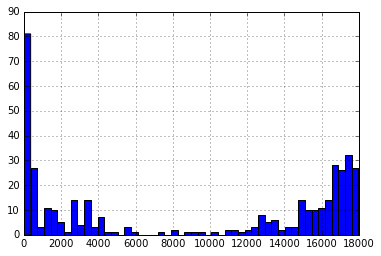

In [114]:
BES_numerics_only[england_only][euRefVote_only].count().hist(bins=50)

In [115]:
BES_numerics_only[england_only][euRefVote_only].count().quantile(.5)

C:\Users\Marios\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


12344.5

In [117]:
BES_clean = BES_numerics_only[england_only][euRefVote_only]
half_complete_var = BES_clean.count() > BES_clean.count().quantile(.5)

C:\Users\Marios\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [118]:
corr = BES_clean.corr()

In [165]:
corr["euRefVote"][BES_numeric.columns[ (var_type["type"]==6)] ]

age    0.235543
Age    0.235727
Name: euRefVote, dtype: float64

In [164]:
corr["euRefVote"]["euID1"]

0.17955895195568769

In [149]:
BES_reduced = BES_clean.loc[:,half_complete_var].copy()

In [145]:
# high correlates with voting leave!
#( after having excluded countries other than England )
#==== LOOK IRRELEVANT - N ~ 4-8
# certaintyEUSNP             0.440368
# ptvSNP                     0.444756

In [150]:
sum(BES_reduced.count())/(BES_reduced.shape[0]*BES_reduced.shape[1])

0.90285487850806589

In [167]:
clean_feature_set_nonan = BES_reduced.fillna(BES_reduced.mean())
from sklearn.preprocessing import StandardScaler
clean_feature_set_std = StandardScaler().fit_transform(clean_feature_set_nonan)
clean_feature_set_std = pd.DataFrame(clean_feature_set_std,
                                     columns = BES_reduced.columns,
                                     index   = BES_reduced.index)



In [222]:
X_std = clean_feature_set_std.drop("id",axis=1)
X = clean_feature_set_std.drop("id",axis=1).drop("euRefVote",axis=1)
y= X_std["euRefVote"]>0

C:\Users\Marios\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


((17979, 10), (17979, 1))
explained variance ratio (first two components): [ 0.17301998  0.04370239  0.04000065  0.0247603   0.0200468   0.01727691
  0.01485694  0.01384083  0.01348572  0.01235611]


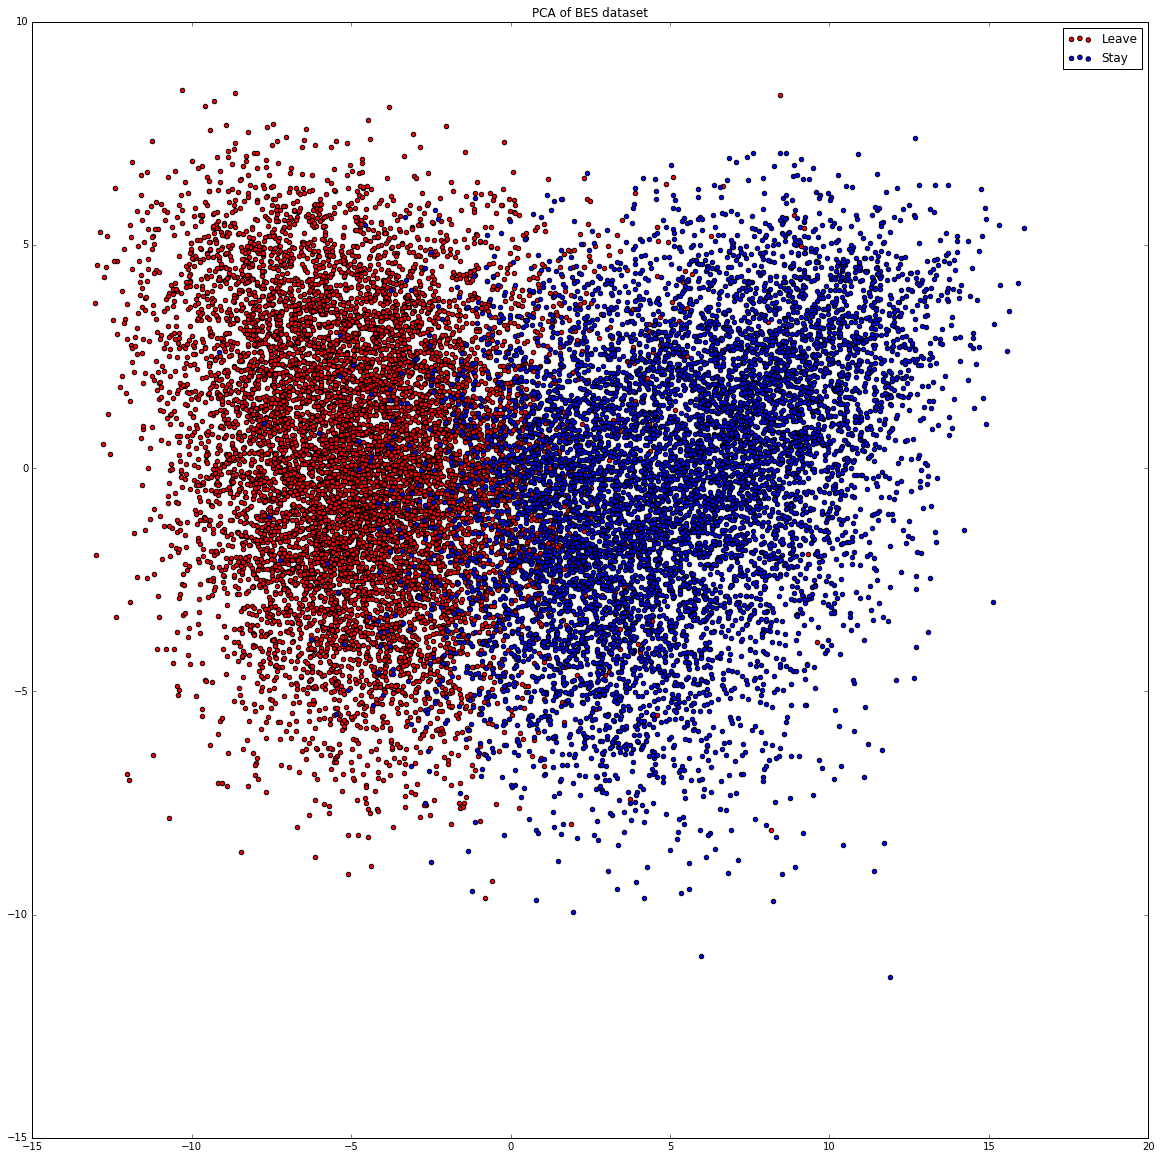

In [177]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis



Leave = X_std["euRefVote"]>0
Stay =  X_std["euRefVote"]<0
target_names = ["Stay","Leave"]

pca = PCA(n_components=10)
X_r = pca.fit(X_std).transform(X_std)


lda = LinearDiscriminantAnalysis(n_components=2)

X_r2 = lda.fit(X, y).transform(X)
print( (X_r.shape, X_r2.shape ) )
# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure(figsize=(20,20))

plt.scatter(X_r[ np.ix_(Leave, [0]) ] , X_r[ np.ix_(Leave, [1]) ], c='r', label="Leave")
plt.scatter(X_r[ np.ix_(Stay, [0]) ]  , X_r[ np.ix_(Stay, [1]) ] , c='b', label="Stay")

plt.legend()
plt.title('PCA of BES dataset')

# plt.figure()
# for c, i, target_name in zip("rg", [False, True], target_names):
#     plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], c=c, label=target_name)
# plt.legend()
# plt.title('LDA of IRIS dataset')

plt.show()

Index(['euUndermineIdentity', 'EUIntegrationSelf', 'euRefVote',
       'UKsovereignty', 'euParlOverRide', 'immigrantsWelfareState',
       'euRefVoteUnsqueeze', 'ukCoopMovement', 'euRefVote2', 'effectsEUEcon',
       'likeUKIP', 'likeFarage', 'effectsEUNHS', 'euLeaveVoice',
       'effectsEUWorkers', 'ukCoopWorkers', 'effectsEUTrade', 'euRedTape',
       'al_scale', 'socialIdentityGlobalLeave', 'euMemberJoin', 'likeBoris',
       'immigContributeTake', 'changeImmig', 'al2', 'blackEquality',
       'leaveTone', 'campaigninfoLeave', 'al1', 'al5', 'likeGove', 'ukCoopCAP',
       'benefitsToMigrants', 'effectsEUFinance', 'proConLeave',
       'childBenefitsRepatriate', 'al3', 'gayEquality', 'immigCon',
       'englishness', 'ukCoopTrade', 'ukCoopEuro', 'franceFairShare',
       'monarch', 'euRefExpectation', 'businessSupport', 'immigLab',
       'leaveImpactSelf', 'EUIntegrationLab', 'edlevel', 'remainTone',
       'euLeaveScotIndep', 'campaigninfoRemain', 'likeLD', 'EUIntegrationCon',
   

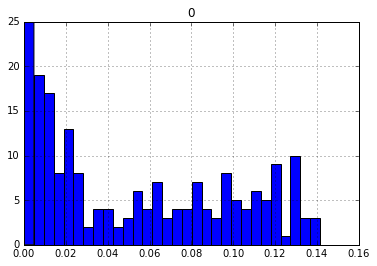

In [190]:
comp_0 = pd.DataFrame(pca.components_[0])
comp_0.abs().hist(bins=30)
comp_0_vars = comp_0[comp_0[0].abs()>.06].sort_values(by=0).index
X_std.columns[comp_0_vars]

Index(['lr_scale', 'likeCon', 'likeCameron', 'likeOsborne', 'changeEconomy',
       'changeNHS', 'changeEducation', 'satDemUK', 'satDemEng',
       'efficacyPolCare', 'lr5', 'lr1', 'lr2', 'lr3', 'lr4'],
      dtype='object')

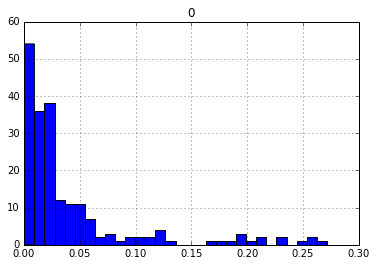

In [180]:
comp_1 = pd.DataFrame(pca.components_[1])
comp_1.abs().hist(bins=30)
comp_1_vars = comp_1[comp_1[0].abs()>.15].sort_values(by=0).index
X_std.columns[comp_1_vars]

Index(['ldSupport', 'certaintyEUUKIP', 'infoSourcePaper', 'certaintyEUGreen',
       'euRefInterest', 'discussPolDays', 'certaintyEULD', 'efficacyEU',
       'efficacyUnderstand', 'polAttention'],
      dtype='object')

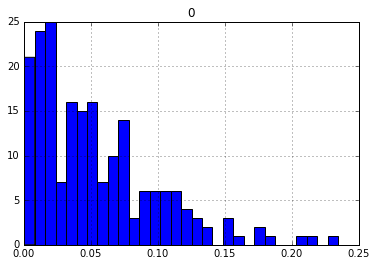

In [182]:
comp_2 = pd.DataFrame(pca.components_[2])
comp_2.abs().hist(bins=30)
comp_2_vars = comp_2[comp_2[0].abs()>.15].sort_values(by=0).index
X_std.columns[comp_2_vars]

Index(['Age', 'age', 'ageGroup', 'profile_education_age',
       'profile_household_children', 'profile_household_size'],
      dtype='object')

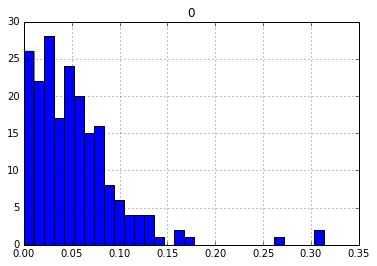

In [183]:
comp_3 = pd.DataFrame(pca.components_[3])
comp_3.abs().hist(bins=30)
comp_3_vars = comp_3[comp_3[0].abs()>.15].sort_values(by=0).index
X_std.columns[comp_3_vars]

Index(['infoSourcePeople', 'ldSupport', 'discussPolDays',
       'infoSourceInternet'],
      dtype='object')

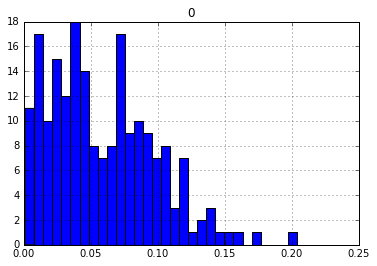

In [188]:
comp_4 = pd.DataFrame(pca.components_[4])
comp_4.abs().hist(bins=30)
comp_4_vars = comp_4[comp_4[0].abs()>.15].sort_values(by=0).index
X_std.columns[comp_4_vars]

In [192]:
from sklearn.decomposition import FastICA
import gc
gc.collect()

0

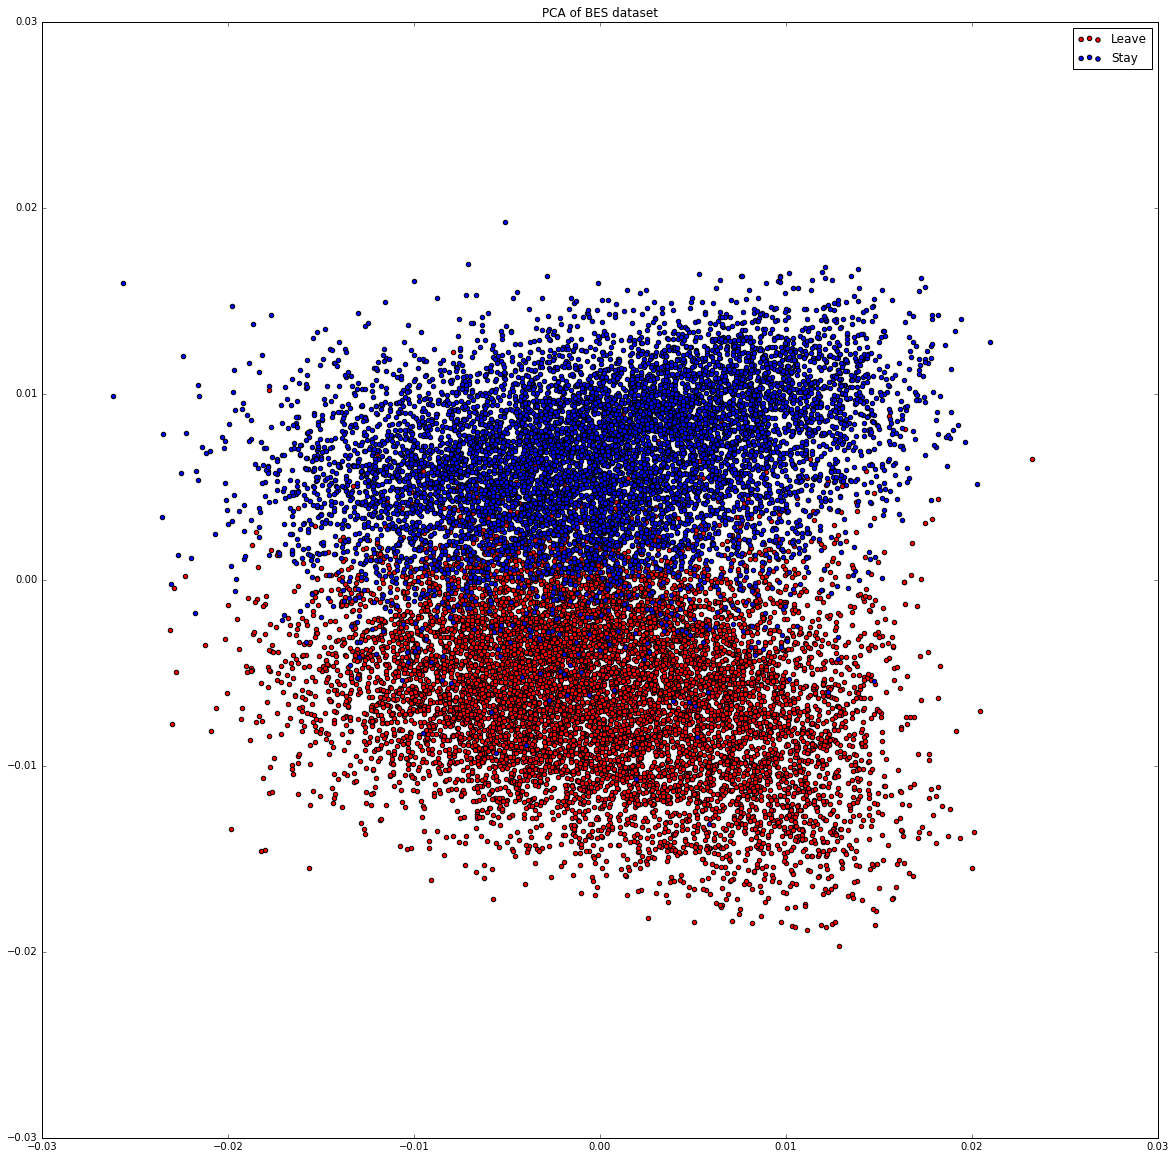

comp: 0 top 40 contributing variables:
                     0            1
0          likeCameron  0.000540415
1             lr_scale  0.000512786
2          likeOsborne  0.000512767
3              likeCon  0.000495511
4                  lr4 -0.000456446
5         polAttention -0.000433939
6             satDemUK  0.000431135
7                  lr2 -0.000429817
8                  lr3 -0.000427615
9            satDemEng  0.000425978
10  efficacyUnderstand -0.000410152
11       changeEconomy  0.000405025
12                 lr1 -0.000401157
13     changeEducation  0.000396265
14          efficacyEU -0.000396146
15           changeNHS  0.000384172
16           conUnited   0.00038361
17      discussPolDays  -0.00036674
18                 lr5 -0.000348097
19       certaintyEULD -0.000310954
20  infoSourceInternet -0.000308848
21    infoSourcePeople -0.000303756
22      certaintyEULab -0.000299455
23    certaintyEUGreen -0.000299121
24         partyMember  -0.00029597
25       euRefInterest -0

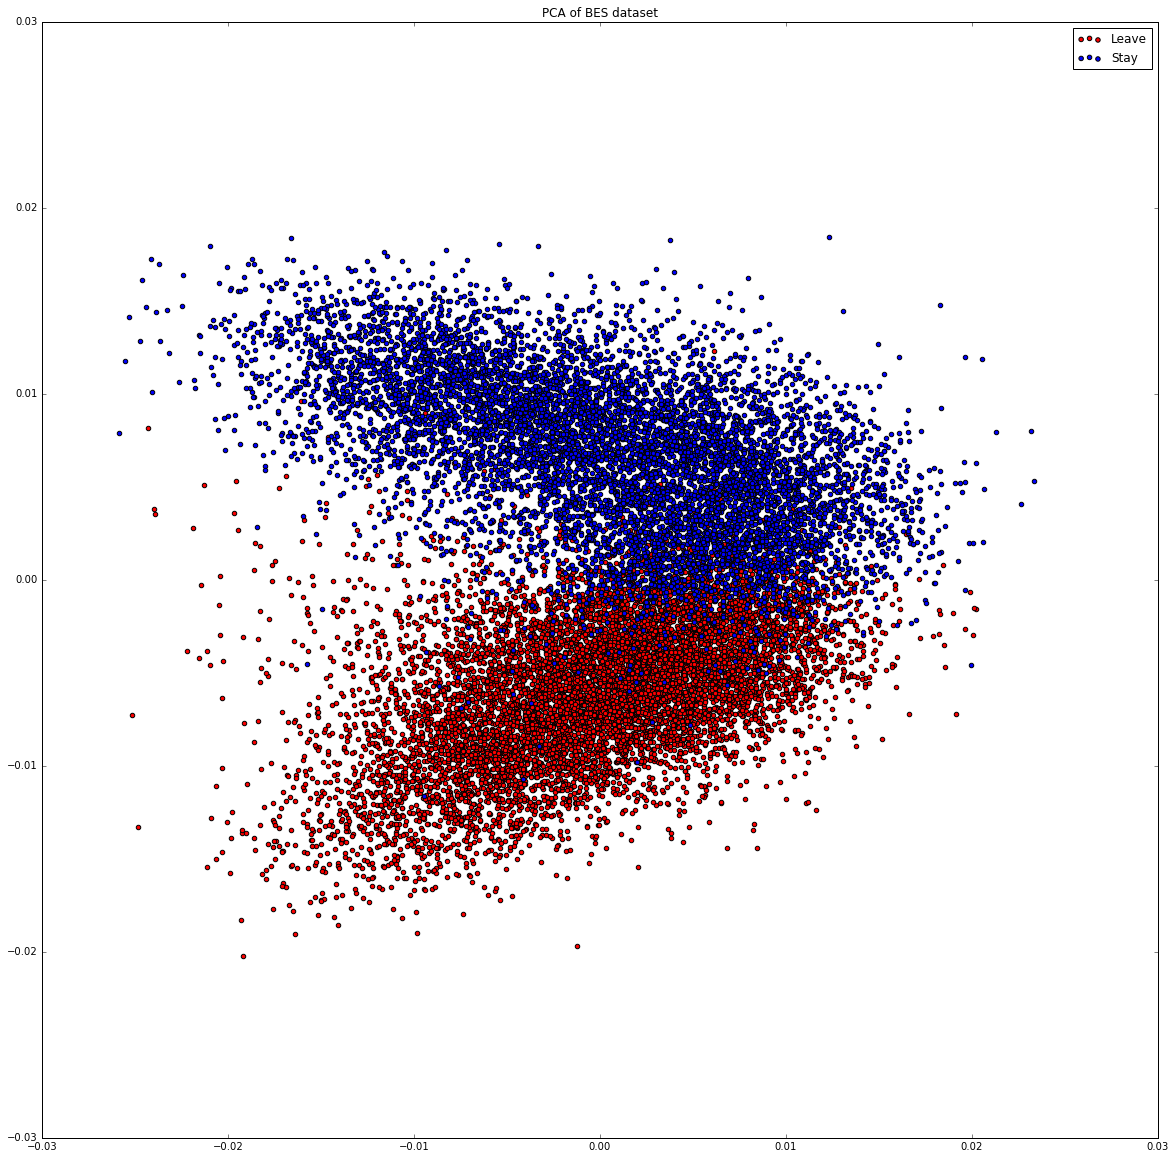

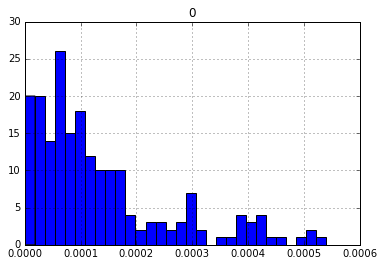

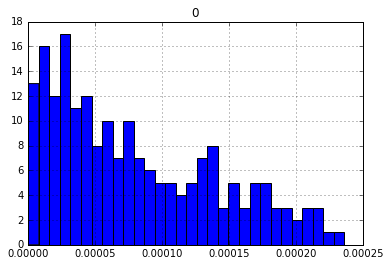

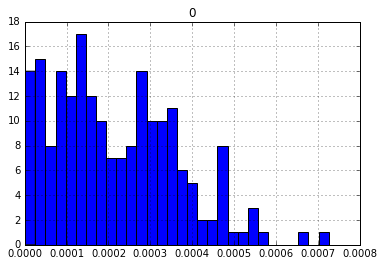

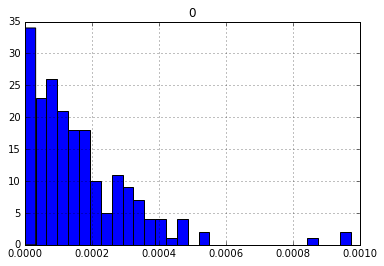

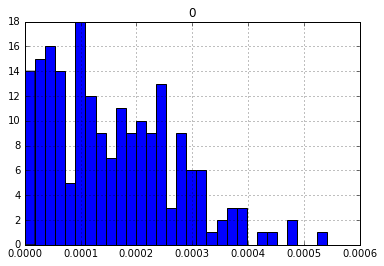

In [293]:
num_comps = 5

decomp = FastICA(n_components=num_comps)
X_r = decomp.fit(X_std).transform(X_std)


plt.figure(figsize=(20,20))

plt.scatter(X_r[ np.ix_(Leave, [0]) ] , X_r[ np.ix_(Leave, [1]) ], c='r', label="Leave")
plt.scatter(X_r[ np.ix_(Stay, [0]) ]  , X_r[ np.ix_(Stay, [1]) ] , c='b', label="Stay")

plt.legend()
plt.title('PCA of BES dataset')

comp_share = np.int(X_std.shape[1]/num_comps)

# comp_thresh = np.zeros(num_comps)
# comp_thresh[0:3] = [0.0004,0.00008,0.0004]
for cp in range(num_comps):
    
    comp = pd.DataFrame(decomp.components_[cp])
    comp.abs().hist(bins=30)
    #comp_vars = comp[comp[0].abs()>comp_thresh[cp]].sort_values(by=0).index
    comp_vars = comp.abs().sort_values(by=0,ascending=False)[0:comp_share].index
    print("comp: "+str(cp), "top "+ str(comp_share) + " contributing variables:") 
    
    print( pd.DataFrame(  [X_std.columns[comp_vars].values, comp.loc[comp_vars ][0]] ).T )

comp: 0 top 40contributing variables:
                            0         1
0         euUndermineIdentity -0.141482
1           EUIntegrationSelf -0.139843
2                   euRefVote -0.138977
3               UKsovereignty  -0.13388
4                 euLawsLevel  0.133752
5                    euUKRich  0.133127
6                   immigSelf  0.131858
7              euParlOverRide  -0.13157
8      immigrantsWelfareState -0.131345
9          euRefVoteUnsqueeze -0.131211
10              immigCultural   0.13054
11             ukCoopMovement -0.130525
12                 euRefVote2 -0.130084
13              effectsEUEcon  -0.12935
14                  immigEcon  0.128474
15                   likeUKIP -0.128027
16                       echr  0.123114
17                   euCloser  0.121181
18                 likeFarage -0.120858
19               effectsEUNHS -0.120826
20               euLeaveVoice -0.120794
21           effectsEUWorkers -0.120219
22                     euMore   0.12017
23

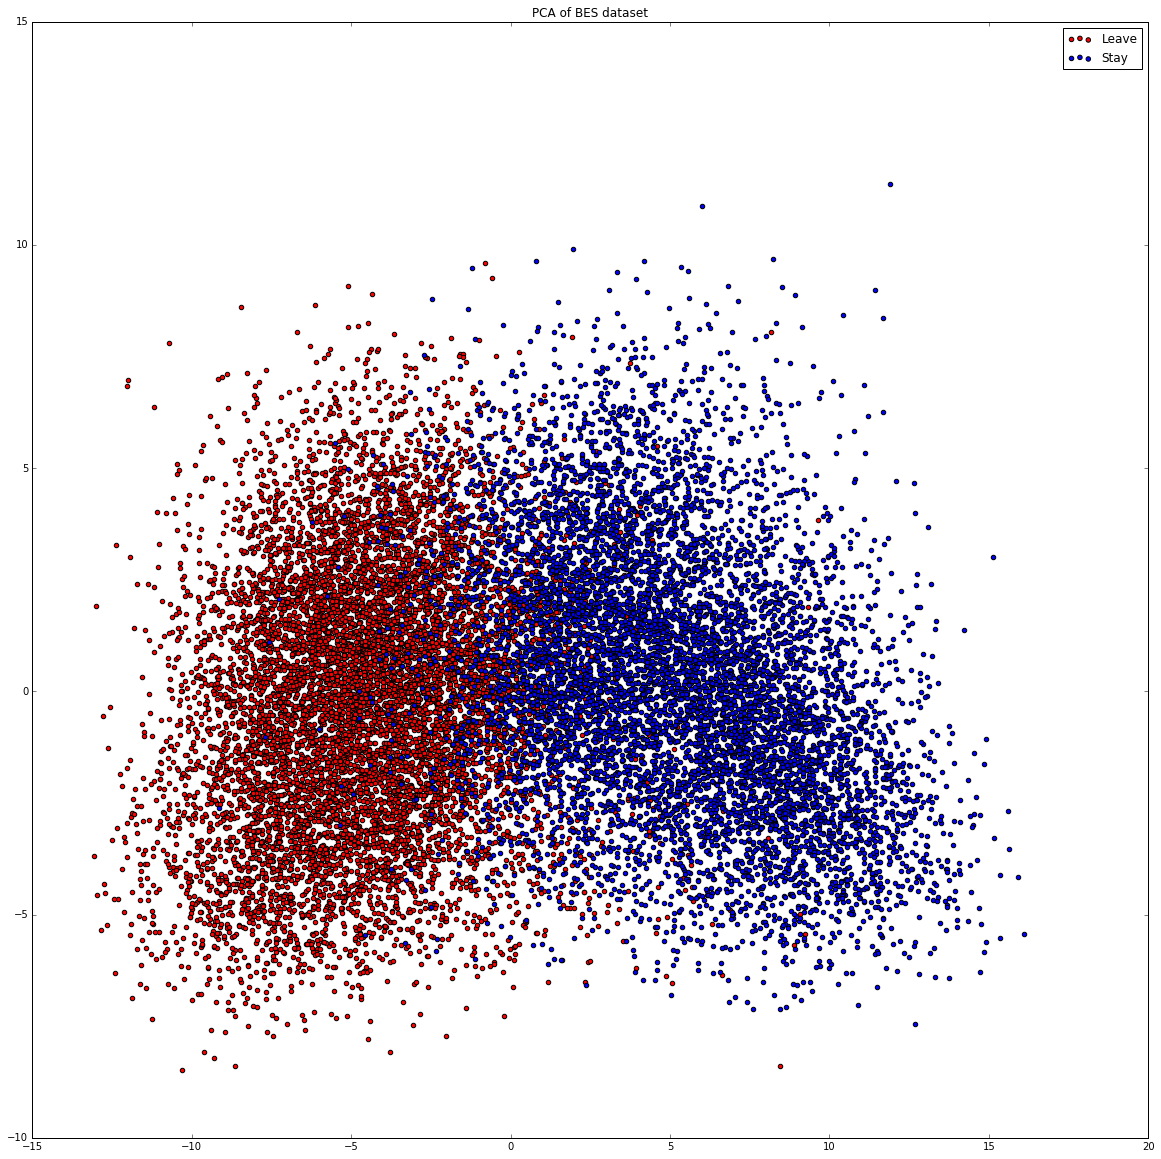

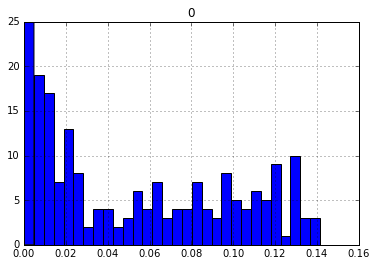

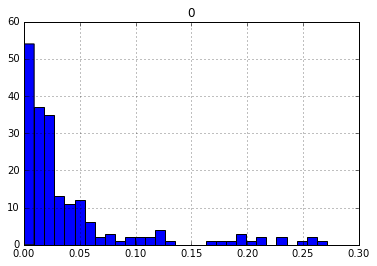

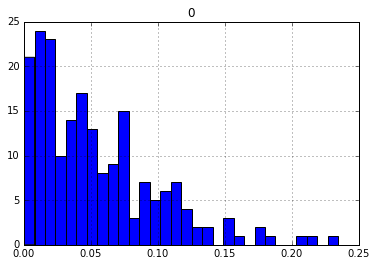

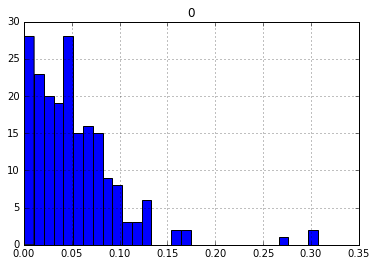

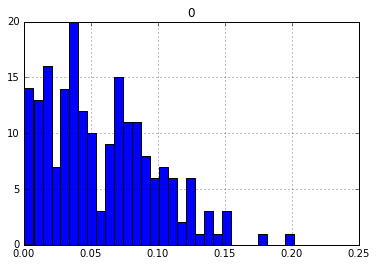

In [291]:
num_comps = 5

decomp = PCA(n_components=num_comps)
X_r = decomp.fit(X_std).transform(X_std)


plt.figure(figsize=(20,20))

plt.scatter(X_r[ np.ix_(Leave, [0]) ] , X_r[ np.ix_(Leave, [1]) ], c='r', label="Leave")
plt.scatter(X_r[ np.ix_(Stay, [0]) ]  , X_r[ np.ix_(Stay, [1]) ] , c='b', label="Stay")

plt.legend()
plt.title('PCA of BES dataset')

comp_share = np.int(X_std.shape[1]/num_comps)

# comp_thresh = np.zeros(num_comps)
# comp_thresh[0:3] = [0.0004,0.00008,0.0004]
for cp in range(num_comps):
    
    comp = pd.DataFrame(decomp.components_[cp])
    comp.abs().hist(bins=30)
    #comp_vars = comp[comp[0].abs()>comp_thresh[cp]].sort_values(by=0).index
    comp_vars = comp.abs().sort_values(by=0,ascending=False)[0:comp_share].index
    print("comp: "+str(cp), "top "+ str(comp_share) + " contributing variables:") 
    
    print( pd.DataFrame(  [X_std.columns[comp_vars].values, comp.loc[comp_vars ][0]] ).T )

comp: 0 top 25 contributing variables:
                             0         1
0                          Age  0.999188
1                          age   0.99915
2                     ageGroup  0.784514
3        profile_education_age -0.428083
4       profile_household_size -0.361708
5                  gayEquality   0.30826
6                 euMemberJoin  0.303542
7                  changeImmig  0.282334
8   profile_household_children -0.280059
9                     al_scale  0.272324
10                 euLawsLevel -0.268881
11           EUIntegrationSelf  0.267924
12         euUndermineIdentity  0.265435
13                        echr  -0.26532
14              ukCoopMovement  0.262944
15                   immigSelf -0.258398
16               UKsovereignty  0.254705
17                infoSourceTV  0.253736
18             franceFairShare  0.252376
19                 englishness  0.249792
20                   noneuMore -0.248678
21                   euRefVote  0.248148
22                

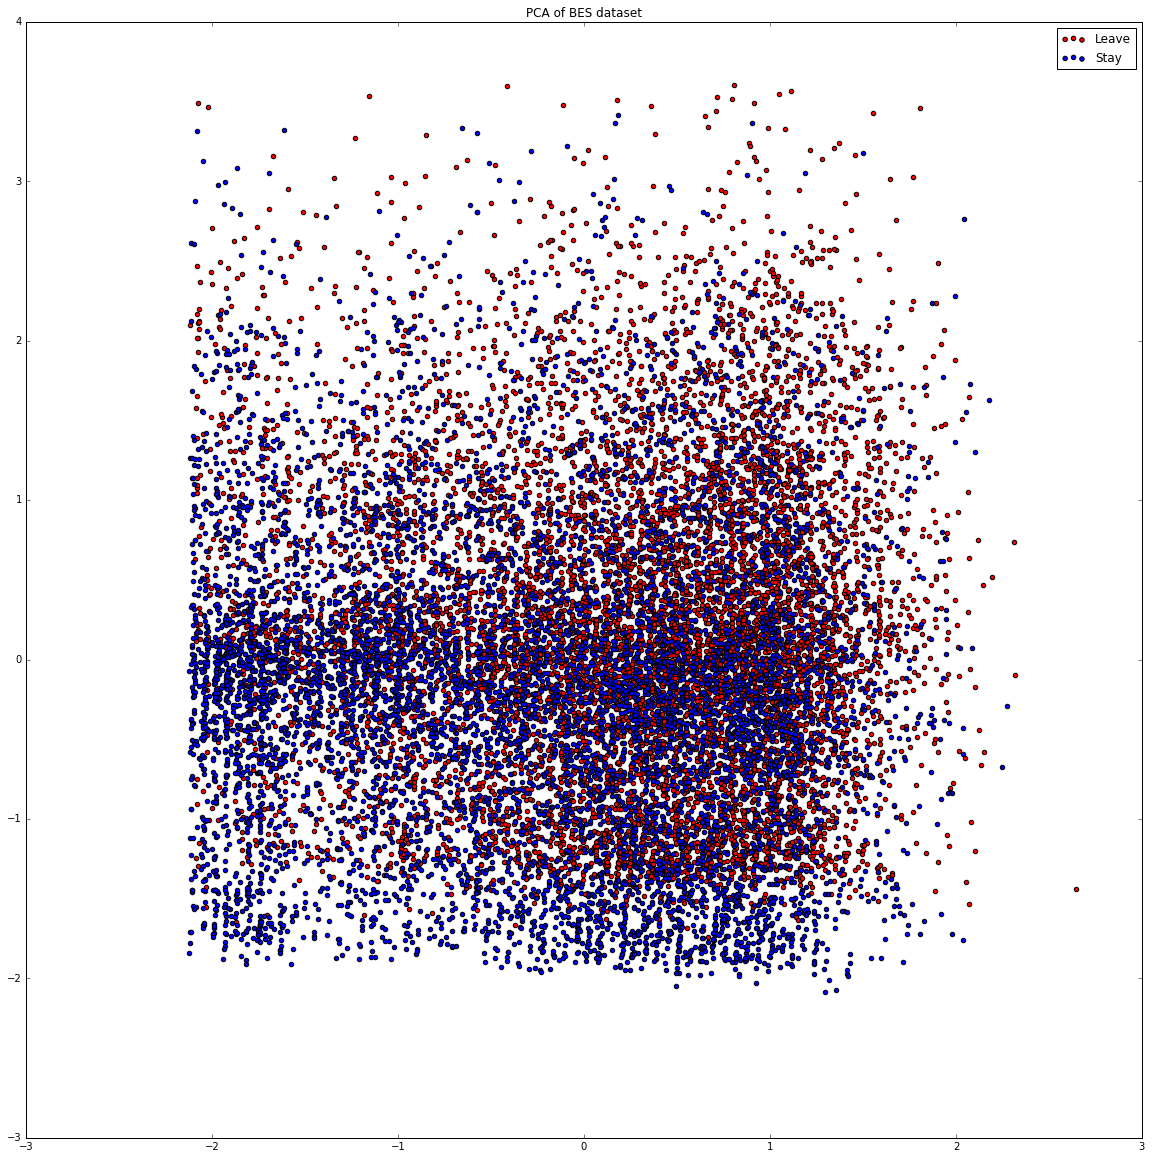

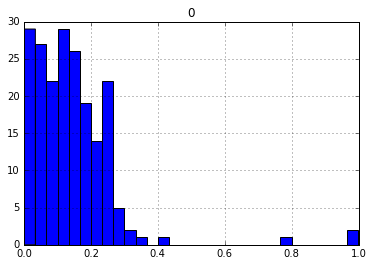

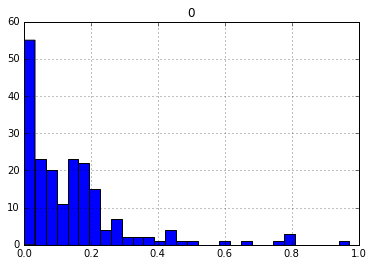

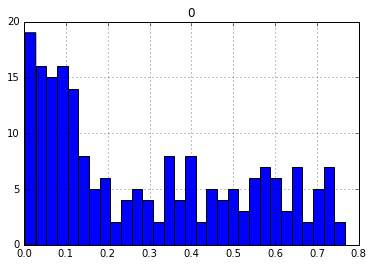

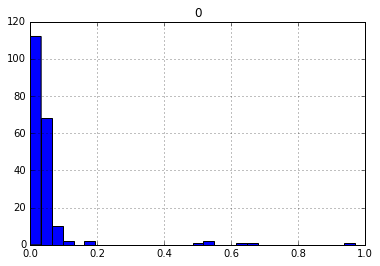

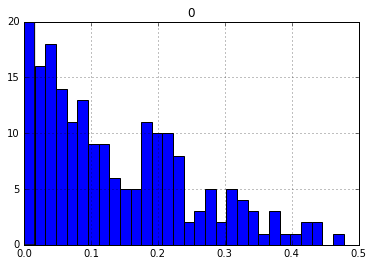

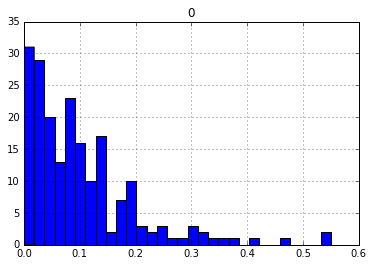

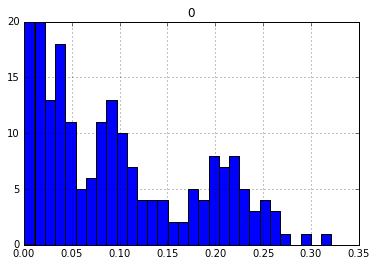

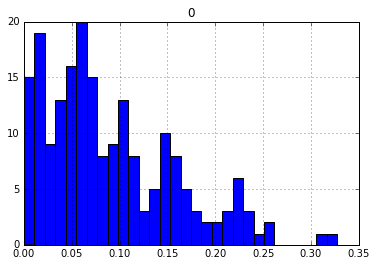

In [298]:
num_comps = 8

from sklearn.decomposition import FactorAnalysis
decomp = FactorAnalysis(n_components=num_comps)
X_r = decomp.fit(X_std).transform(X_std)


plt.figure(figsize=(20,20))

plt.scatter(X_r[ np.ix_(Leave, [0]) ] , X_r[ np.ix_(Leave, [1]) ], c='r', label="Leave")
plt.scatter(X_r[ np.ix_(Stay, [0]) ]  , X_r[ np.ix_(Stay, [1]) ] , c='b', label="Stay")

plt.legend()
plt.title('PCA of BES dataset')

comp_share = np.int(X_std.shape[1]/num_comps)

# comp_thresh = np.zeros(num_comps)
# comp_thresh[0:3] = [0.0004,0.00008,0.0004]
for cp in range(num_comps):
    
    comp = pd.DataFrame(decomp.components_[cp])
    comp.abs().hist(bins=30)
    #comp_vars = comp[comp[0].abs()>comp_thresh[cp]].sort_values(by=0).index
    comp_vars = comp.abs().sort_values(by=0,ascending=False)[0:comp_share].index
    print("comp: "+str(cp), "top "+ str(comp_share) + " contributing variables:") 
    
    print( pd.DataFrame(  [X_std.columns[comp_vars].values, comp.loc[comp_vars ][0]] ).T )

NameError: name 'BES' is not defined

In [302]:
BES["age"]-BES["Age"]

0        2.0
1        2.0
2        2.0
3        2.0
4        2.0
5        2.0
6        2.0
7        2.0
8        2.0
9        2.0
10       2.0
11       2.0
12       2.0
13       2.0
14       2.0
15       2.0
16       2.0
17       2.0
18       2.0
19       2.0
20       2.0
21       2.0
22       2.0
23       2.0
24       2.0
25       2.0
26       2.0
27       2.0
28       2.0
29       2.0
        ... 
31379    NaN
31380    NaN
31381    NaN
31382    NaN
31383    NaN
31384    NaN
31385    NaN
31386    NaN
31387    NaN
31388    NaN
31389    NaN
31390    NaN
31391    NaN
31392    NaN
31393    NaN
31394    NaN
31395    NaN
31396    NaN
31397    NaN
31398    NaN
31399    NaN
31400    NaN
31401    NaN
31402    NaN
31403    NaN
31404    NaN
31405    NaN
31406    NaN
31407    NaN
31408    NaN
dtype: float64

In [ ]:
# 0                          Age  0.999188
# 1                          age   0.99915
# 2                     ageGroup  0.784514